## Introduction

<p> The datasets now made available were collected aiming at the development of prediction models to classify a hotel booking׳s likelihood to be canceled. <br>
Nevertheless, due to the characteristics of the variables included in these datasets, their use goes beyond this cancellation prediction problem. <br>
One of the most important properties in data for prediction models is not to promote leakage of future information. <br> In order to prevent this from happening, the timestamp of the target variable must occur after the input variables’ timestamp. <br> Thus, instead of directly extracting variables from the bookings database table, when available, the variables’ values were extracted from the bookings change log, <br> with a timestamp relative to the day prior to arrival date (for all the bookings created before their arrival date). </p>

### Libraries

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
style.use('seaborn-poster')
style.use('ggplot')
import plotly.express as px
import seaborn as sn

# Algorithms
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier)
from sklearn.neural_network import MLPClassifier

from xgboost import plot_tree
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from time import time
from time import sleep
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import resample

# RNN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from tensorflow.keras.layers import  Dense,  BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
from keras import backend as K
from keras.optimizers import Adam, SGD


#Shap & Eli5
import shap
import eli5 as eli


#Categories
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

Using TensorFlow backend.


In [2]:
matplotlib.style.use('seaborn-poster')
matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'

In [3]:
df = pd.read_csv('hotel_bookings.csv')
df = df.reindex(sorted(df.columns), axis = 1)
df

,adr,adults,agent,arrival_date_day_of_month,arrival_date_month,arrival_date_week_number,arrival_date_year,assigned_room_type,babies,booking_changes,...,meal,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,reservation_status,reservation_status_date,reserved_room_type,stays_in_week_nights,stays_in_weekend_nights,total_of_special_requests
0,0.00,2,NaN,1,July,27,2015,C,0,3,...,BB,0,0,0,Check-Out,2015-07-01,C,0,0,0
1,0.00,2,NaN,1,July,27,2015,C,0,4,...,BB,0,0,0,Check-Out,2015-07-01,C,0,0,0
2,75.00,1,NaN,1,July,27,2015,C,0,0,...,BB,0,0,0,Check-Out,2015-07-02,A,1,0,0
3,75.00,1,304.0,1,July,27,2015,A,0,0,...,BB,0,0,0,Check-Out,2015-07-02,A,1,0,0
4,98.00,2,240.0,1,July,27,2015,A,0,0,...,BB,0,0,0,Check-Out,2015-07-03,A,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,96.14,2,394.0,30,August,35,2017,A,0,0,...,BB,0,0,0,Check-Out,2017-09-06,A,5,2,0
119386,225.43,3,9.0,31,August,35,2017,E,0,0,...,BB,0,0,0,Check-Out,2017-09-07,E,5,2,2
119387,157.71,2,9.0,31,August,35,2017,D,0,0,...,BB,0,0,0,Check-Out,2017-09-07,D,5,2,4
119388,104.40,2,89.0,31,August,35,2017,A,0,0,...,BB,0,0,0,Check-Out,2017-09-07,A,5,2,0


<ul>
  <li>adr: Average Daily Rate </li>
  <li>agent: ID of travel agency</li>
  <li>DaysInWaitingList: Number of days the booking was in the waiting list before it was confirmed to the customer</li>
  <li>DistributionChannel: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”</li>
  <li>LeadTime: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date</li>
  <li>Meal: Undefined/SC – no meal package;
            BB – Bed & Breakfast;
HB – Half board (breakfast and one other meal – usually dinner);
FB – Full board (breakfast, lunch and dinner)</li>    
</ul>
<br>
<br>

<p>Company has the 94% of na values, I decide to remove it </p>

<AxesSubplot:xlabel='percentage', ylabel='column'>

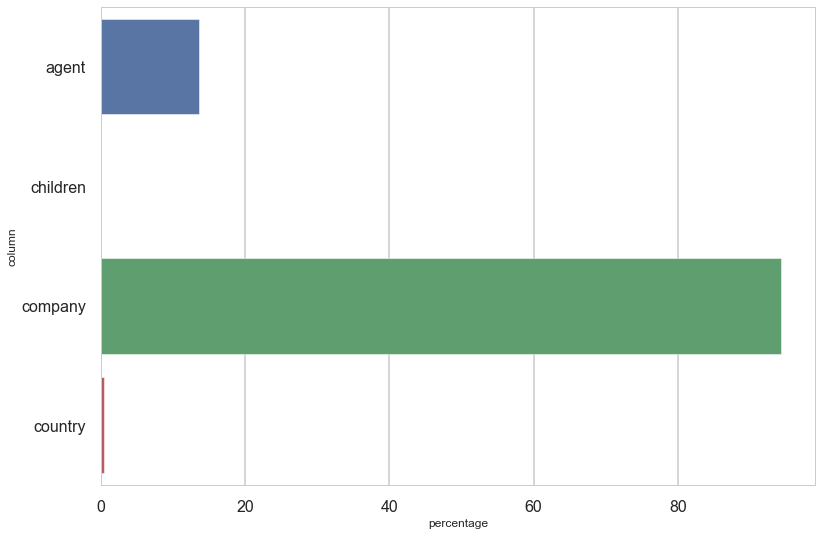

In [145]:
na=pd.DataFrame(df.isna().sum()/119390*100)
na.reset_index(inplace=True)
na.columns=["column","percentage"]
na=na[na["percentage"]!=0]
sns.set_style("whitegrid")
sns.barplot(x = na.percentage , y = na.column, palette = "deep")


In [146]:
del df['company']

In [147]:
na_cols = df.isna().any()
na_cols = na_cols[na_cols == True].reset_index()

na_cols = na_cols["index"].tolist()
for col in df.columns[1:]:
     if col in na_cols:
        if df[col].dtype != 'object':
             df[col] =  df[col].fillna(df[col].mean()).round(0)

In [148]:
df.isna().any()

adr                               False
adults                            False
agent                             False
arrival_date_day_of_month         False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_year                 False
assigned_room_type                False
babies                            False
booking_changes                   False
children                          False
country                            True
customer_type                     False
days_in_waiting_list              False
deposit_type                      False
distribution_channel              False
hotel                             False
is_canceled                       False
is_repeated_guest                 False
lead_time                         False
market_segment                    False
meal                              False
previous_bookings_not_canceled    False
previous_cancellations            False
required_car_parking_spaces       False


<p>Now, I remove the all na rows from the dataset </p>

In [149]:
df = df.dropna()
df.isna().sum()/119390*100

adr                               0.0
adults                            0.0
agent                             0.0
arrival_date_day_of_month         0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_year                 0.0
assigned_room_type                0.0
babies                            0.0
booking_changes                   0.0
children                          0.0
country                           0.0
customer_type                     0.0
days_in_waiting_list              0.0
deposit_type                      0.0
distribution_channel              0.0
hotel                             0.0
is_canceled                       0.0
is_repeated_guest                 0.0
lead_time                         0.0
market_segment                    0.0
meal                              0.0
previous_bookings_not_canceled    0.0
previous_cancellations            0.0
required_car_parking_spaces       0.0
reservation_status                0.0
reservation_

### Plot Histogram of numeric Columns

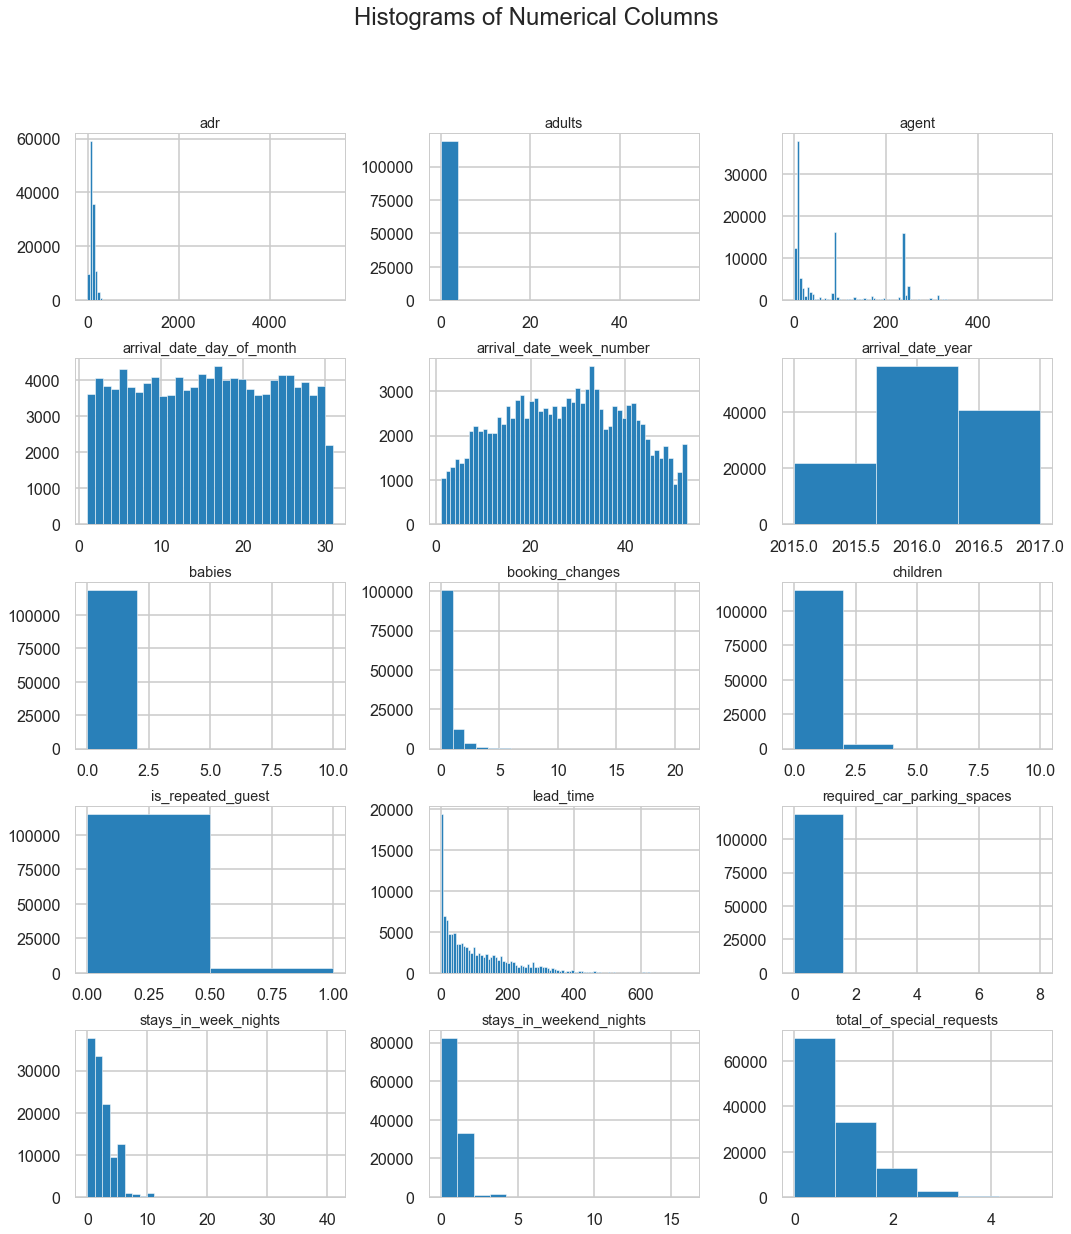

In [150]:
dataset2 = df[['adr', 'adults', 'agent', 'arrival_date_day_of_month',
       'arrival_date_week_number', 'arrival_date_year', 'babies',
        'booking_changes', 'children', 
       'is_repeated_guest', 'lead_time',
        'required_car_parking_spaces',
        'stays_in_week_nights','stays_in_weekend_nights','total_of_special_requests']]


    
fig = plt.figure(figsize=(15, 18))
plt.suptitle('Histograms of Numerical Columns\n',horizontalalignment = "center",fontstyle = "normal", fontsize = 24, fontfamily = "sans-serif")
for i in range(dataset2.shape[1]):
    plt.subplot(5, 3, i + 1)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i])

    vals = np.size(dataset2.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    
    plt.hist(dataset2.iloc[:, i], bins=vals, color="#2980b9")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [151]:
df.reset_index(inplace = True)

In [152]:
df.head()

,index,adr,adults,agent,arrival_date_day_of_month,arrival_date_month,arrival_date_week_number,arrival_date_year,assigned_room_type,babies,...,meal,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,reservation_status,reservation_status_date,reserved_room_type,stays_in_week_nights,stays_in_weekend_nights,total_of_special_requests
0,0,0.0,2,87.0,1,July,27,2015,C,0,...,BB,0,0,0,Check-Out,2015-07-01,C,0,0,0
1,1,0.0,2,87.0,1,July,27,2015,C,0,...,BB,0,0,0,Check-Out,2015-07-01,C,0,0,0
2,2,75.0,1,87.0,1,July,27,2015,C,0,...,BB,0,0,0,Check-Out,2015-07-02,A,1,0,0
3,3,75.0,1,304.0,1,July,27,2015,A,0,...,BB,0,0,0,Check-Out,2015-07-02,A,1,0,0
4,4,98.0,2,240.0,1,July,27,2015,A,0,...,BB,0,0,0,Check-Out,2015-07-03,A,2,0,1


### Overall Cancelletion  Rate

ipykernel_launcher:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



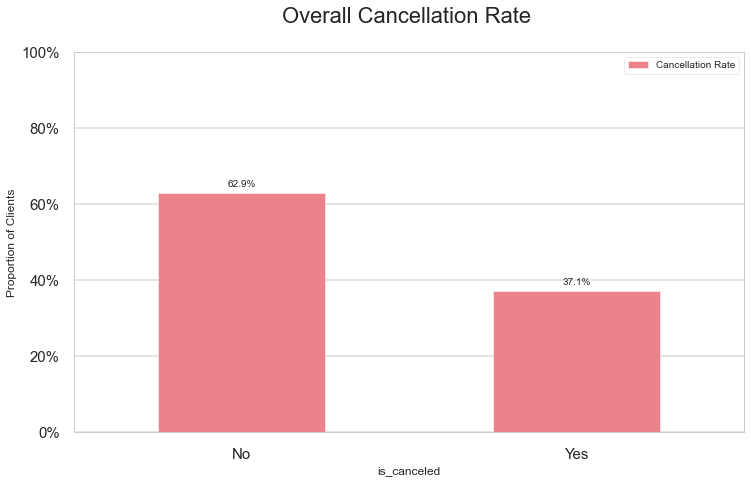

In [153]:
import matplotlib.ticker as mtick
rate = df[["is_canceled", "index"]]
rate ["is_canceled"] = pd.Series(np.where((rate["is_canceled"] == 0), "No", "Yes"))
sectors = rate .groupby ("is_canceled")
rate = pd.DataFrame(sectors["index"].count())
rate ["Cancellation Rate"] = (rate ["index"] / sum(rate ["index"]) )*100
ax =  rate[["Cancellation Rate"]].plot.bar(title = 'Overall Cancellation Rate', legend =True, table = False, grid = False,  subplots = False,  figsize =(12, 7), color = '#ec838a', fontsize = 15, stacked=False, ylim =(0,100))
plt.grid(color="black", axis="y", linewidth=0.2)
plt.ylabel('Proportion of Clients',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('is_canceled',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Overall Cancellation Rate \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
x_labels = np.array(rate[["index"]])

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing
        va = 'bottom'        
        if y_value < 0:           
            space *= -1          
            va = 'top'
        
        label = "{:.1f}%".format(y_value)    
        ax.annotate(
            label,                      
            (x_value, y_value),        
            xytext=(0, space),         
            textcoords="offset points", 
            ha='center',                
            va=va)                                                            
add_value_labels(ax)
ax.autoscale(enable=False, axis='both', tight=False) 

In [154]:
df['is_canceled'].value_counts()

0    74745
1    44157
Name: is_canceled, dtype: int64

In [155]:
df_majority = df[df.is_canceled == 0]
df_minority = df[df.is_canceled == 1]
 
# Upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace = False,    # sample without replacement
                                 n_samples = 44157,     # to match minority class
                                 random_state = 0) # reproducible results
 
# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df.is_canceled.value_counts()

0    44157
1    44157
Name: is_canceled, dtype: int64

In [156]:
df[df['is_canceled'] == 1]['total_of_special_requests']

8         1
9         0
10        0
27        2
31        2
         ..
109792    3
110867    0
111436    0
111437    0
116807    1
Name: total_of_special_requests, Length: 44157, dtype: int64

<p> Correlation from variables, We don't see any tipe of significant correlation</p>

In [157]:
df.corr()

,index,adr,adults,agent,arrival_date_day_of_month,arrival_date_week_number,arrival_date_year,babies,booking_changes,children,days_in_waiting_list,is_canceled,is_repeated_guest,lead_time,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,stays_in_week_nights,stays_in_weekend_nights,total_of_special_requests
index,1.000000,0.114012,-0.023185,-0.571866,0.010199,-0.047571,0.260449,-0.026447,-0.003996,-0.038321,-0.005737,-0.267676,-0.004123,0.007911,0.011958,-0.016152,-0.102508,-0.216329,-0.161009,0.093402
adr,0.114012,1.000000,0.197739,-0.007573,0.033591,0.067003,0.208115,0.026532,0.023275,0.325311,-0.045124,0.045958,-0.125831,-0.092851,-0.063963,-0.074689,0.051932,0.070409,0.052989,0.160583
adults,-0.023185,0.197739,1.000000,-0.027862,0.000235,0.025869,0.026450,0.012371,-0.043199,0.024546,-0.010941,0.058345,-0.129478,0.110642,-0.094026,-0.005182,0.010089,0.079887,0.079941,0.103156
agent,-0.571866,-0.007573,-0.027862,1.000000,-0.002786,-0.034611,0.074404,0.031046,0.064624,0.049910,-0.060507,-0.079987,0.017647,-0.075968,0.007892,-0.008672,0.139407,0.181157,0.141789,0.045180
arrival_date_day_of_month,0.010199,0.033591,0.000235,-0.002786,1.000000,0.060953,-0.002126,-0.000095,0.010288,0.014068,0.021791,-0.007635,-0.005031,-0.004915,0.002159,-0.031483,0.009462,-0.028255,-0.012934,0.006405
arrival_date_week_number,-0.047571,0.067003,0.025869,-0.034611,0.060953,1.000000,-0.538802,0.012154,0.003679,0.003936,0.016300,0.006242,-0.018047,0.133829,-0.016776,0.044749,0.002786,0.006747,0.012505,0.027599
arrival_date_year,0.260449,0.208115,0.026450,0.074404,-0.002126,-0.538802,1.000000,-0.017695,0.034263,0.058843,-0.055542,0.015826,-0.008241,0.020109,0.028338,-0.142200,-0.012263,0.041045,0.025804,0.107575
babies,-0.026447,0.026532,0.012371,0.031046,-0.000095,0.012154,-0.017695,1.000000,0.082868,0.021802,-0.010303,-0.033698,-0.009790,-0.023213,-0.005141,-0.007606,0.032755,0.016677,0.020048,0.095755
booking_changes,-0.003996,0.023275,-0.043199,0.064624,0.010288,0.003679,0.034263,0.082868,1.000000,0.051463,-0.015005,-0.159584,0.015158,-0.014465,0.017344,-0.029732,0.069189,0.077991,0.050425,0.068594
children,-0.038321,0.325311,0.024546,0.049910,0.014068,0.003936,0.058843,0.021802,0.051463,1.000000,-0.035522,0.006277,-0.031076,-0.044379,-0.018044,-0.027702,0.050374,0.056590,0.055778,0.080361


<AxesSubplot:>

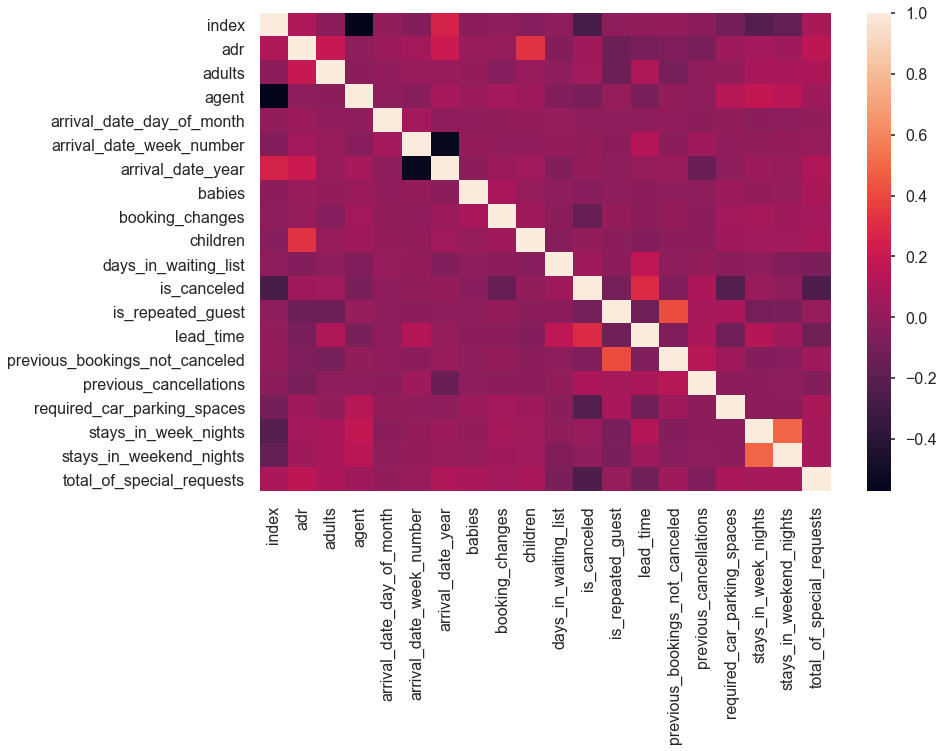

In [158]:
sns.heatmap(df.corr(), 
        xticklabels = df.corr().columns,
        yticklabels = df.corr().columns)

## Feature Engineering and EDA

<p> Canculation of the number of cancellation per day </p>

In [159]:
df_canceled = df.copy()

In [160]:
df_canceled['datetime'] = pd.to_datetime(df_canceled['arrival_date_year'].map(str) + " " + df_canceled['arrival_date_month'].map(str) + " " + df_canceled['arrival_date_day_of_month'].map(str))
df['datetime'] = pd.to_datetime(df['arrival_date_year'].map(str) + " " + df['arrival_date_month'].map(str) + " " + df['arrival_date_day_of_month'].map(str))
del df['arrival_date_year']
del df['arrival_date_month']
del df['arrival_date_day_of_month']

In [161]:
df_canceled = df_canceled[df_canceled['is_canceled'] == 1]

In [162]:
df_canceled = pd.DataFrame(df_canceled.groupby('datetime').count()['is_canceled'])

In [163]:
df_canceled.reset_index(inplace = True)

In [164]:
df_canceled.columns = ['datetime', 'number_of_cancellation']

In [165]:
df = df_canceled.merge(df)

<p> Total number of people in family </p>

In [166]:
df['family'] = df['adults'] + df['babies'] + df['children']


In [167]:
#Drop rows where family = 0 -> no guests

df = df.drop(df[df['family'] == 0].index)

In [168]:
df.head()

,datetime,number_of_cancellation,index,adr,adults,agent,arrival_date_week_number,assigned_room_type,babies,booking_changes,...,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,reservation_status,reservation_status_date,reserved_room_type,stays_in_week_nights,stays_in_weekend_nights,total_of_special_requests,family
0,2015-07-01,19,75546,80.0,1,6.0,27,A,0,1,...,0,0,0,Check-Out,2015-07-03,A,2,0,0,1.0
1,2015-07-01,19,3,75.0,1,304.0,27,A,0,0,...,0,0,0,Check-Out,2015-07-02,A,1,0,0,1.0
2,2015-07-01,19,75559,80.0,1,6.0,27,A,0,1,...,0,0,0,Check-Out,2015-07-03,A,2,0,0,1.0
3,2015-07-01,19,75549,80.0,1,6.0,27,A,0,1,...,0,0,0,Check-Out,2015-07-03,A,2,0,0,1.0
4,2015-07-01,19,75571,101.5,2,6.0,27,A,0,0,...,0,0,0,Check-Out,2015-07-03,A,2,0,0,2.0


In [169]:
#sns.boxplot(df, palette="deep")

<p> Balance of target class </p>

In [170]:
df.is_canceled

0        0
1        0
2        0
3        0
4        0
        ..
88309    1
88310    1
88311    1
88312    1
88313    1
Name: is_canceled, Length: 88208, dtype: int64

<p> Distribution of adr </p>

In [171]:
df[df['adr'] == 0]['is_canceled']

8        0
25       0
28       0
308      0
348      0
        ..
87722    0
87847    0
88063    1
88184    0
88222    0
Name: is_canceled, Length: 1130, dtype: int64

In [172]:
df['normalized_adr'] = (df['adr'] - min(df['adr'])) / (max(df['adr']) - min(df['adr'])) * 100
df['normalized_adr']

0        1.481481
1        1.388889
2        1.481481
3        1.481481
4        1.879630
           ...   
88309    1.833333
88310    3.425926
88311    1.535926
88312    3.000000
88313    3.500000
Name: normalized_adr, Length: 88208, dtype: float64

<p> Distribution of people for country </p>

In [173]:
df.country

0        PRT
1        GBR
2        PRT
3        PRT
4        PRT
        ... 
88309    DEU
88310    GRC
88311    PRT
88312    RUS
88313    RUS
Name: country, Length: 88208, dtype: object

In [174]:
country_data = pd.DataFrame(df.loc[df["is_canceled"] == 0]["country"].value_counts())
total_guests = country_data["country"].sum()
country_data["%_guests"] = round(country_data["country"] / total_guests * 100, 2)
country_data["country"] = country_data.index

In [175]:
country_data

,country,%_guests
PRT,PRT,28.22
GBR,GBR,13.04
FRA,FRA,11.29
ESP,ESP,8.44
DEU,DEU,8.11
...,...,...
TZA,TZA,0.00
LAO,LAO,0.00
SYR,SYR,0.00
TMP,TMP,0.00


In [176]:
guest_map = px.choropleth(country_data,
                    locations = country_data.index,
                    color = country_data["%_guests"], 
                    hover_name = country_data.index, 
                    color_continuous_scale = px.colors.sequential.Plasma,
                    title = "Home country of guests")
guest_map.show()

<p> How much did they pay? </p>

In [177]:
df.groupby(['hotel', 'assigned_room_type']).mean()['adr']

hotel         assigned_room_type
City Hotel    A                      96.552985
              B                      93.855411
              C                     100.895500
              D                     124.107245
              E                     147.828755
              F                     182.137673
              G                     186.870089
              K                      73.518548
Resort Hotel  A                      82.132360
              B                     100.937100
              C                     118.541691
              D                      91.251736
              E                     111.258497
              F                     122.690856
              G                     164.828935
              H                     175.453965
              I                      45.947594
              L                       8.000000
Name: adr, dtype: float64

In [178]:
df = df[df['adr'] >= 0]

<AxesSubplot:xlabel='datetime', ylabel='adr'>

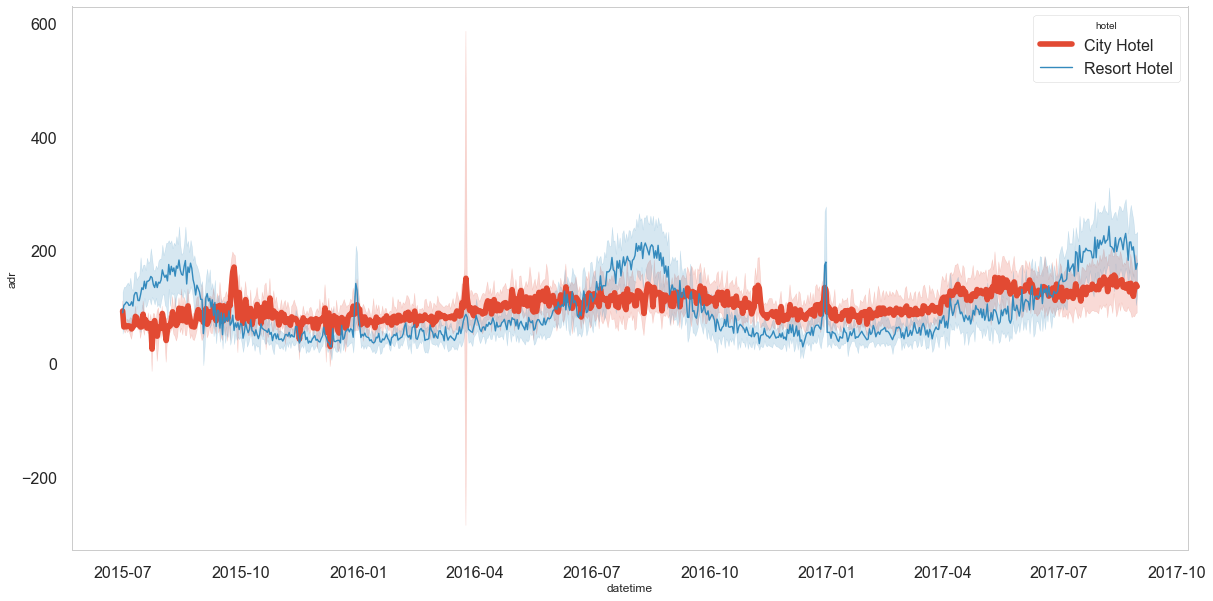

In [179]:
df['arrival_date_month'] = pd.Categorical(df['datetime'], categories = months, ordered = True)
room_prices_mothly = df[["hotel", "datetime", "adr"]].sort_values("datetime")

plt.figure(figsize=(20, 10))
plt.grid(color="black", linewidth=0.2)
sns.lineplot(x = "datetime", y = "adr", hue = "hotel", data = room_prices_mothly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci = "sd", size = "hotel")

<p> Type of meal </p>

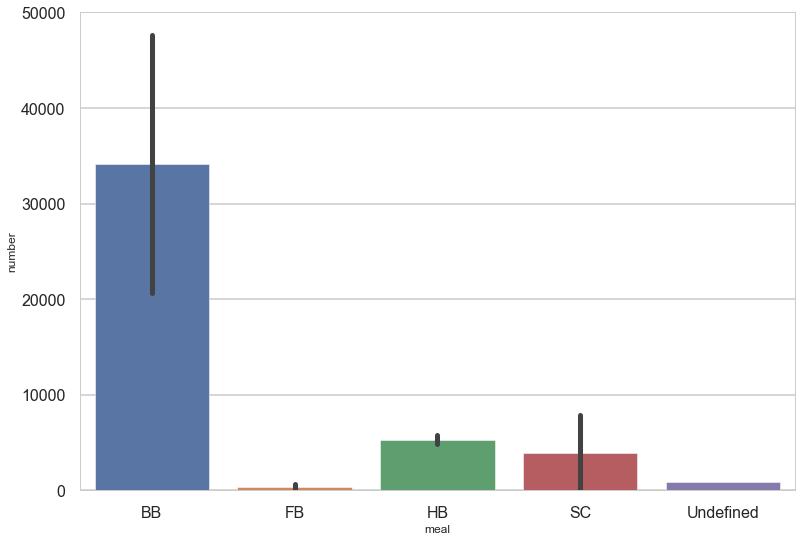

In [180]:
meal_frame = pd.DataFrame(df.groupby(['hotel', 'meal']).count()['index'])
meal_frame = meal_frame.reset_index()
meal_frame.columns = ['hotel', 'meal', 'number']
sns.barplot(x = meal_frame.meal , y = meal_frame.number, palette = "deep")
sns.set_style("darkgrid")

<p> Most important variables in case of cancellation </p>

<AxesSubplot:xlabel='correlation_grade', ylabel='column'>

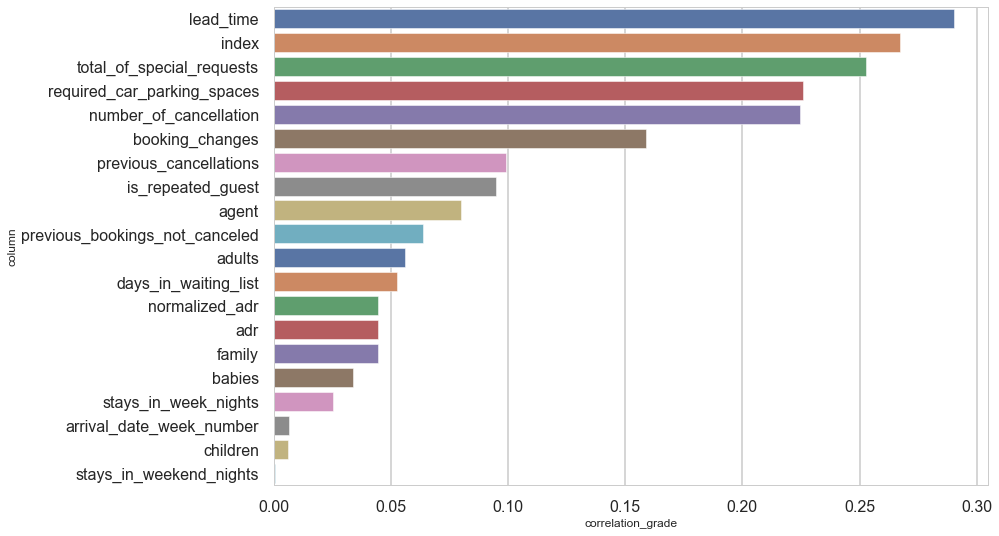

In [181]:
cancel_corr = df.corr()["is_canceled"]
cancel_corr=cancel_corr.abs().sort_values(ascending=False)[1:]
cancel_corr=pd.DataFrame(cancel_corr)
cancel_corr.reset_index(inplace=True)
cancel_corr.columns=["column","correlation_grade"]
cancel_corr=cancel_corr[cancel_corr["correlation_grade"]!=0]
sns.set_style("whitegrid")
sns.barplot(x = cancel_corr.correlation_grade , y = cancel_corr.column, palette = "deep")


## Models

<p> Remove insignificant variables and transform objects variables into dummy variables </p>

In [182]:
del df['customer_type']
del df['deposit_type']
del df['distribution_channel']
del df['market_segment']
del df['reservation_status']
del df['reservation_status_date']
del df['arrival_date_month']
del df['normalized_adr']

In [183]:
df = pd.get_dummies(df)
df

,datetime,number_of_cancellation,index,adr,adults,agent,arrival_date_week_number,babies,booking_changes,children,...,meal_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L
0,2015-07-01,19,75546,80.00,1,6.0,27,0,1,0.0,...,0,1,0,0,0,0,0,0,0,0
1,2015-07-01,19,3,75.00,1,304.0,27,0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
2,2015-07-01,19,75559,80.00,1,6.0,27,0,1,0.0,...,0,1,0,0,0,0,0,0,0,0
3,2015-07-01,19,75549,80.00,1,6.0,27,0,1,0.0,...,0,1,0,0,0,0,0,0,0,0
4,2015-07-01,19,75571,101.50,2,6.0,27,0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88309,2017-08-31,45,73709,99.00,2,9.0,35,0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
88310,2017-08-31,45,73710,185.00,2,9.0,35,0,0,0.0,...,0,0,0,0,0,1,0,0,0,0
88311,2017-08-31,45,73711,82.94,2,22.0,35,0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
88312,2017-08-31,45,73712,162.00,3,9.0,35,0,0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [184]:
del df['index']

<p> Prepare dataset for models </p>

In [185]:
X = df.copy() # Features
del X['is_canceled']
del X['datetime']
y = df.is_canceled # Target variable

In [186]:
X.to_csv("dummies.csv")

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
print(X_train.shape, y_train.shape)

(70566, 209) (70566,)


### Feature Scaling

In [188]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

In [189]:
X_train.head()

,number_of_cancellation,adr,adults,agent,arrival_date_week_number,babies,booking_changes,children,days_in_waiting_list,is_repeated_guest,...,meal_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L
65418,-0.330520,-1.394338,0.223596,-0.746165,-1.200706,-0.072185,-0.320479,-0.260255,-0.140623,-0.170965,...,-0.09657,0.607381,-0.096719,-0.087404,-0.428898,-0.232232,-0.155499,-0.132528,-0.072007,-0.008418
415,-1.085681,0.301034,0.223596,-0.775504,0.059779,-0.072185,-0.320479,-0.260255,-0.140623,-0.170965,...,-0.09657,-1.646414,-0.096719,-0.087404,2.331556,-0.232232,-0.155499,-0.132528,-0.072007,-0.008418
31291,-0.219466,0.139154,0.223596,-0.531007,-0.385098,-0.072185,-0.320479,-0.260255,-0.140623,-0.170965,...,-0.09657,0.607381,-0.096719,-0.087404,-0.428898,-0.232232,-0.155499,-0.132528,-0.072007,-0.008418
5732,-1.063470,1.845189,0.223596,1.542328,0.727095,10.156303,-0.320479,-0.260255,-0.140623,-0.170965,...,-0.09657,-1.646414,-0.096719,-0.087404,-0.428898,-0.232232,6.430905,-0.132528,-0.072007,-0.008418
31186,1.224224,1.108492,0.223596,-0.707045,-0.385098,-0.072185,-0.320479,-0.260255,0.019635,-0.170965,...,-0.09657,0.607381,-0.096719,-0.087404,-0.428898,-0.232232,-0.155499,-0.132528,-0.072007,-0.008418


<p> List of models </p>

In [106]:
dt = DecisionTreeClassifier()

rf = RandomForestClassifier()

xgb = XGBClassifier(use_label_encoder = False, eval_metric = "logloss")

lgbm = LGBMClassifier()

ada = AdaBoostClassifier()

ex = ExtraTreeClassifier()

### First Evaluation of all models with Holdout method

In [107]:
# Training and testing all classifiers extracting accuracy, and run time.

classifiers = [dt, rf, xgb, lgbm, ada, ex]
classifier_name = ["DecisionTree", "Random Forest", "XtremeGradientBoosting", "LightGradientBoosting", "AdaBoost", "ExtraTreeClassifier"]
df_results = pd.DataFrame(columns = ['classifier', 'accuracy', 'run_time'])
i = 0
    
for classifier in classifiers:
    # Pipeline
    
    start_time = time()
    classifier.fit(X_train, y_train)
    run_time = time() - start_time
    
    # Test
    predicted = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    df_results = df_results.append({'classifier': classifier_name[i], 'accuracy' : accuracy, 'run_time' : run_time}, ignore_index = True)   
    i += 1
    
df_results

[16:51:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,classifier,accuracy,run_time
0,DecisionTree,0.841968,1.025231
1,Random Forest,0.877735,12.752811
2,XtremeGradientBoosting,0.862487,4.097454
3,LightGradientBoosting,0.857216,0.762177
4,AdaBoost,0.812776,6.542437
5,ExtraTreeClassifier,0.807448,0.247560


<p> Best model is XGB, based on the accuracy and the run time <br>
Shap help us to understand which value is very important for our model <br>
[Shap Explanation] https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d </p>

In [108]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

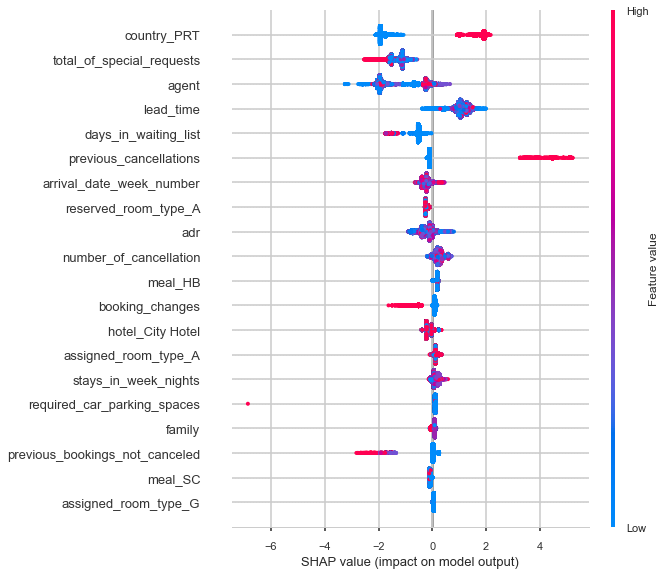

In [109]:
shap.summary_plot(shap_values, features = X, feature_names = X.columns)

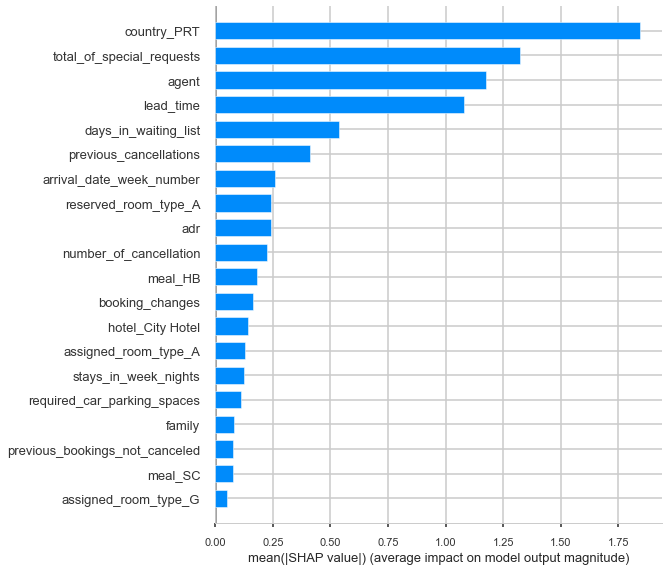

In [110]:
shap.summary_plot(shap_values, features = X, feature_names = X.columns, plot_type = 'bar')

[16:52:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




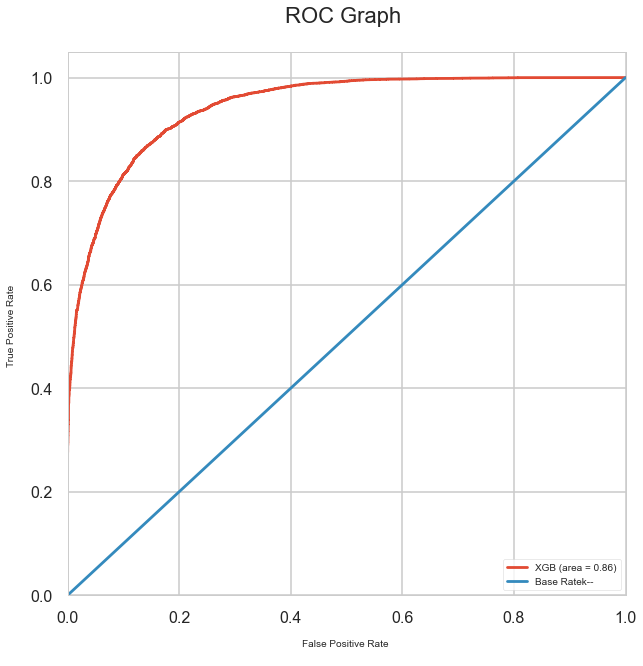

In [111]:
#Evaluate the model using ROC Graph

xgb.fit(X_train, y_train) 
# Predicting the Test set results 
y_pred = xgb.predict(X_test)
probs = xgb.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred)


rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure(figsize=(10, 10))

# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, label='XGB (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])



plt.ylabel('True Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")



plt.show()

### Second Evaluation of all models with 5 CV

<p> We've decided to remove the other classifiers for an eccessive time of computation </p>

In [113]:
# Training and testing all classifiers extracting accuracy, and run time.
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 0)
classifiers = [xgb, lgbm]
classifier_name = ["XGB", "LGBM"]
df_results = pd.DataFrame(columns = ['classifier', 'accuracy', 'std', 'run_time'])
i = 0
    
for classifier in classifiers:
    
    # Test
    scores = cross_validate(classifier, X, y, cv = cv)
    run_time = scores['fit_time'] + scores['score_time']
    run_time = np.sum(run_time)
    accuracy = scores['test_score'].mean() 
    std = scores['test_score'].std()
    df_results = df_results.append({'classifier': classifier_name[i], 'accuracy' : accuracy, 'std' : std, 'run_time' : run_time}, ignore_index = True)   
    i += 1
    
df_results

[16:55:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:55:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:56:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are 

,classifier,accuracy,std,run_time
0,XGB,0.862001,0.002380,105.107002
1,LGBM,0.856532,0.002361,14.086211


<p> Based on Accuracy and Run time we've decided to use XGB </p>

In [114]:
 xgb = XGBClassifier()

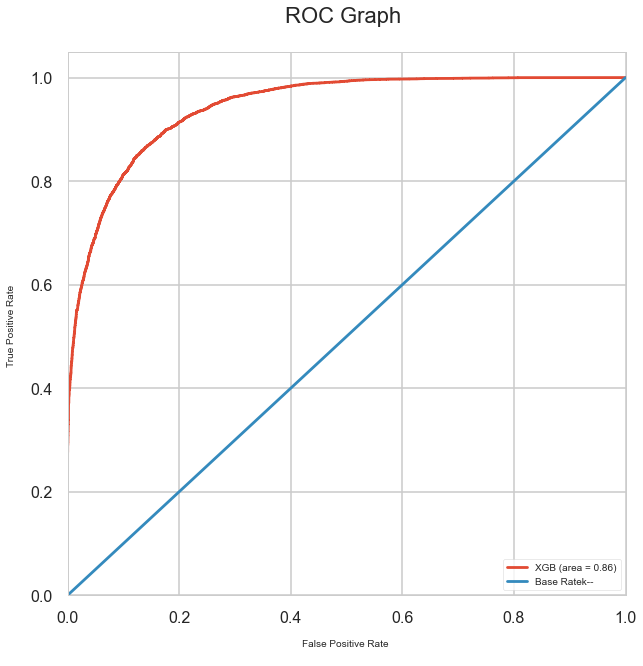

In [115]:
#Evaluate the model using ROC Graph

xgb.fit(X_train, y_train) 
# Predicting the Test set results 
y_pred = xgb.predict(X_test)
probs = xgb.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )


rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 10))

# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, label = 'XGB (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1], label = 'Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])



plt.ylabel('True Positive Rate \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc = "lower right", fontsize = "medium")
plt.xticks(rotation = 0, horizontalalignment = "center")
plt.yticks(rotation = 0, horizontalalignment = "right")



plt.show()

Text(0.5, 45.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

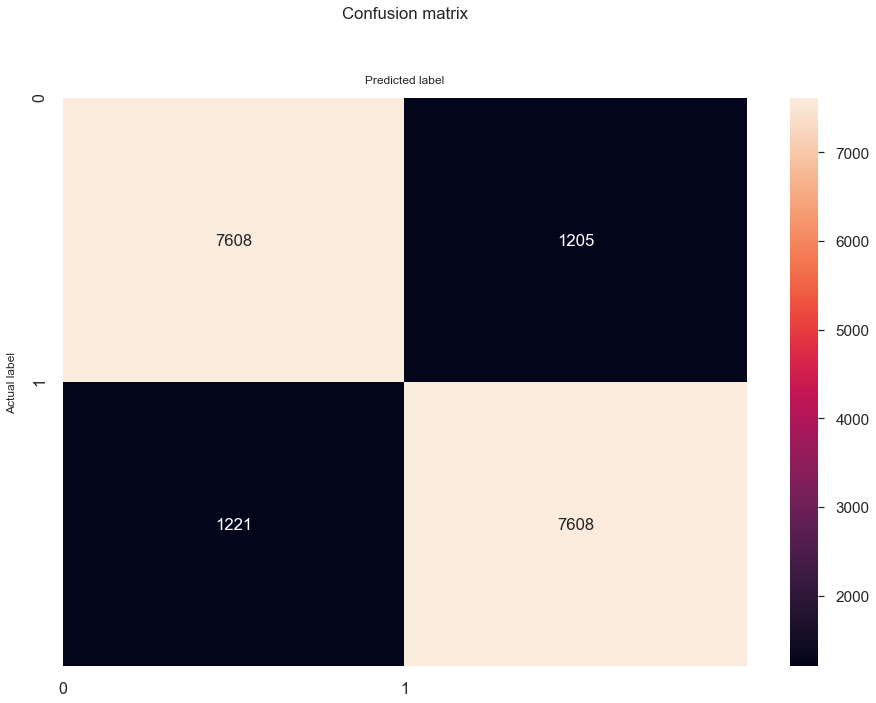

In [116]:
#Visualize results on a Confusion Matrix:
    
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))


fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

### FIRST GridSearch on XGB

In [117]:
xgb_grid = XGBClassifier(tree_method = "hist",  use_label_encoder = False, eval_metric = "logloss", nthread = -1)
param_grid = {
            "n_estimators"     : range(100, 200, 10),
            "learning_rate"    : [0.05, 0.1, 0.3, 0.5],
            "max_depth"        : [3, 5, 7, 10, 12]
            }

cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 0)

grid = GridSearchCV(xgb_grid, param_grid = param_grid, verbose = 1, cv = cv)
start_time = time()
grid.fit(X, y)
run_time = time() - start_time
run_time

 be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:05:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please o

452.3317129611969

In [118]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 190}

In [119]:
xgb_grid1 = XGBClassifier(**grid.best_params_)

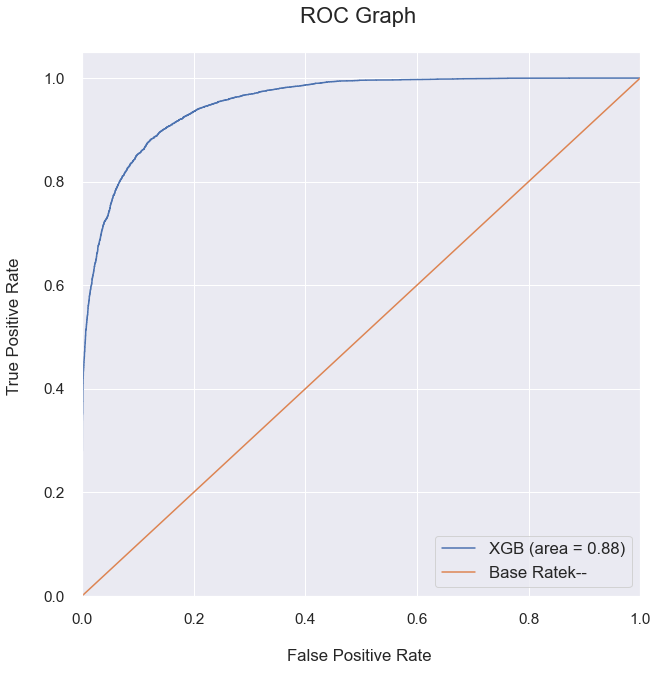

Run Time 13.878175020217896
Accuracy: 0.8790386577485546


In [120]:
#Evaluate the model using ROC Graph

start_time = time()
xgb_grid1.fit(X_train, y_train) 
run_time = time() - start_time
# Predicting the Test set results 
y_pred = xgb_grid1.predict(X_test)
probs = xgb_grid1.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )


rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, xgb_grid1.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 10))

# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, label = 'XGB (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1], label = 'Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])



plt.ylabel('True Positive Rate \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc = "lower right", fontsize = "medium")
plt.xticks(rotation = 0, horizontalalignment = "center")
plt.yticks(rotation = 0, horizontalalignment = "right")



plt.show()
print("Run Time", run_time)
print("Accuracy:", accuracy_score(y_test, y_pred))

<Figure size 2016x1440 with 0 Axes>

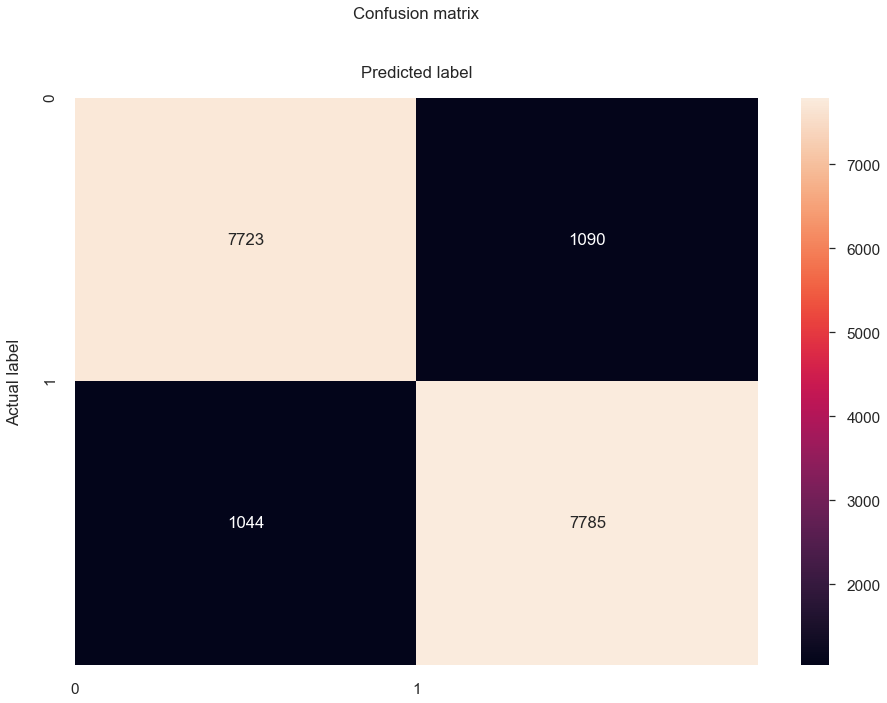

In [122]:
#Visualize results on a Confusion Matrix:

cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))


fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
accuracy = accuracy_score(y_test, y_pred)

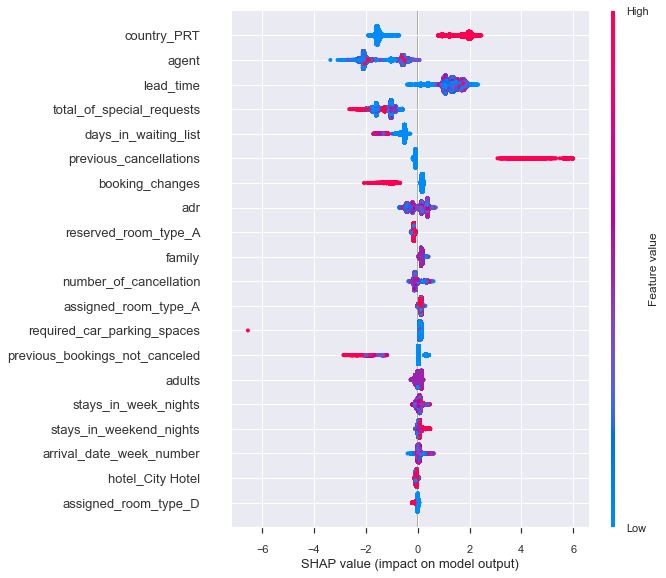

In [123]:
explainer = shap.TreeExplainer(xgb_grid1)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features = X, feature_names = X.columns)

<p> Accuracy is increased from 0.85 to 0.88 with the GridSearch above, we've decided to improve the GridSearch with a second step of <br> Hyperparameter Tuning. <br>
 We've increased the number of estimators and we want to try to increase the depth of the model. <br>
 Furthermore we've decided to increase the Cross Validation value from 2 to 5</p>

### SECOND GridSearch on XGB

In [124]:
xgb_grid2 = XGBClassifier(tree_method = "hist", use_label_encoder = False, eval_metric = "logloss", nthread = -1,
                            learning_rate = 0.1, max_depth = 12, n_estimators = 190)
param_grid = {
            'colsample_bytree': [0.7, 0.8],
            'reg_alpha': [1.1, 1.2, 1.3],
            'reg_lambda': [1.1, 1.2, 1.3],
            }

cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 0)

grid2 = GridSearchCV(xgb_grid2, param_grid = param_grid, verbose = 1, cv = cv)
start_time = time()
grid2.fit(X, y)
run_time = time() - start_time
run_time

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[17:11:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:11:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be 

71.94612193107605

In [125]:
grid2.best_params_

{'colsample_bytree': 0.7, 'reg_alpha': 1.3, 'reg_lambda': 1.2}

In [127]:
xgb_grid2 = XGBClassifier(tree_method = "hist", use_label_encoder = False, eval_metric = "logloss", nthread = -1,
                            learning_rate = 0.1, max_depth = 12, n_estimators = 190, colsample_bytree = 0.7,
                            reg_alpha = 1.3, reg_lambda = 1.2)

[17:13:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




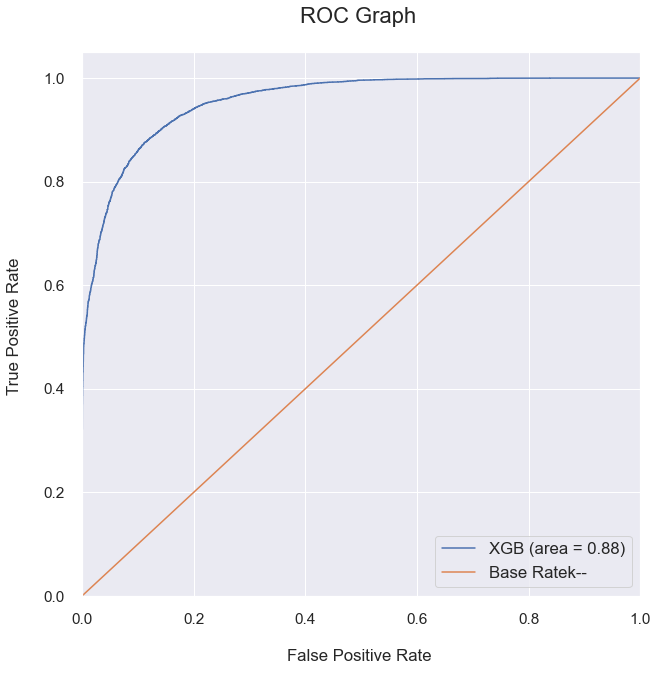

Run Time 2.1009681224823
Accuracy: 0.8810792427162453


In [128]:
start_time = time()
xgb_grid2.fit(X_train, y_train)
run_time = time() - start_time 
# Predicting the Test set results 
y_pred = xgb_grid2.predict(X_test)
probs = xgb_grid2.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )


rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, xgb_grid2.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 10))

# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, label = 'XGB (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1], label = 'Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])



plt.ylabel('True Positive Rate \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n', horizontalalignment = "center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc = "lower right", fontsize = "medium")
plt.xticks(rotation = 0, horizontalalignment = "center")
plt.yticks(rotation = 0, horizontalalignment = "right")



plt.show()

print("Run Time", run_time)
print("Accuracy:", accuracy_score(y_test, y_pred))

<Figure size 2016x1440 with 0 Axes>

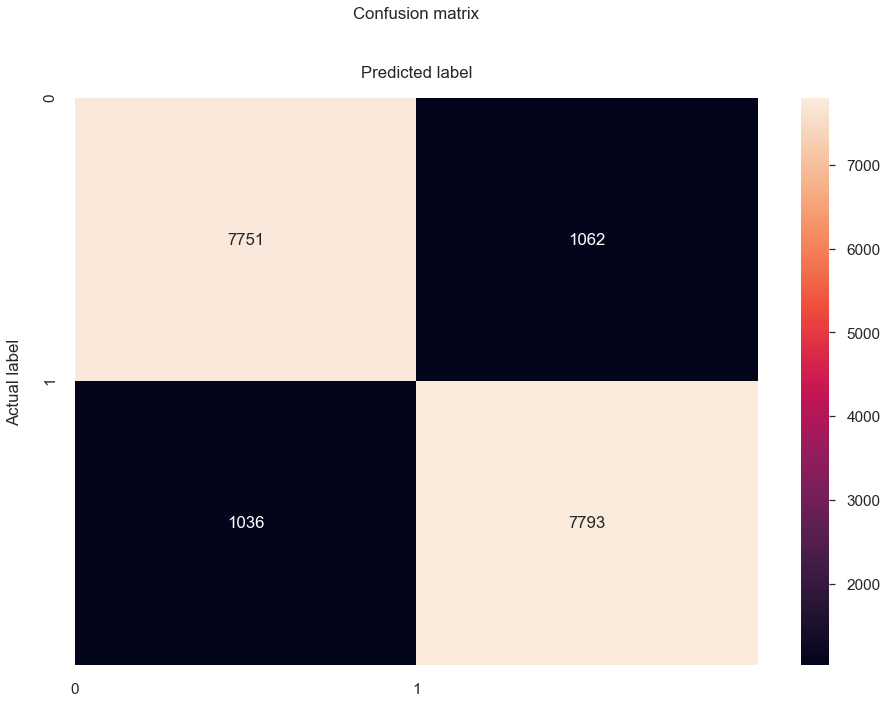

In [129]:
#Visualize results on a Confusion Matrix:

cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))


fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
accuracy = accuracy_score(y_test, y_pred)

# Conclusions
<style>
table {
border-collapse:collapse;
align : center
}
td, th {
border:1px solid #ddd;
padding:8px;
}
</style>

<p> It was decided to use XGB from the start given the best performance both in terms of efficiency and effectiveness. <br>
From here it was decided to perform two GridSearch to search for the best hyperparameters of the model <br>
Below a table with the final results and the plot of the best model <br>
<table>
<tr><td>Model</td><td>Accuracy</td><td> Run Time</td></tr>
<tr><td> Base XGB </td><td>0.86</td><td>4 secs </td></tr>
<tr><td> XGB GridSearch 1 </td><td>0.88</td><td> 13 secs </td></tr>
<tr><td> XGB GridSearch 2 </td><td>0.89</td><td> 2 secs </td></tr>
</table>
</p>

In [130]:
import pickle
#Saving the Model
pickle_out = open("xgb_grid2.pkl", "wb") 
pickle.dump(xgb_grid2, pickle_out) 
pickle_out.close()